# Multivariate Time-Series Anomaly Detection for Equipment Sensors

Objective:
Detect anomalies in multivariate sensor data using:
- Feature-based Isolation Forest
- Sequence-based LSTM Autoencoder

## Technologies
Python, pandas, scikit-learn, tsfresh (documented), Keras, Jupyter Notebook


In [1]:
import tsfresh
import tensorflow as tf

print("tsfresh version:", tsfresh.__version__)
print("tensorflow version:", tf.__version__)


tsfresh version: 0.21.1
tensorflow version: 2.20.0


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest


## Dataset Description

The dataset contains multivariate time-series data collected from multiple
equipment sensors. Each row represents sensor readings at a specific timestamp.
The data is used to identify abnormal behavior that may indicate equipment
faults or unusual operating conditions.


In [5]:
df = pd.read_csv("equipment_sensors.csv")
df.head()


,timestamp,sensor_1,sensor_2,sensor_3,sensor_4
0,2024-01-01 00:00:00,52.483571,34.198066,65.273752,80.921924
1,2024-01-01 00:01:00,49.308678,32.773901,68.988369,91.396150
2,2024-01-01 00:02:00,53.238443,30.178891,64.453061,95.863945
3,2024-01-01 00:03:00,57.615149,28.059190,67.844269,118.876877
4,2024-01-01 00:04:00,48.829233,32.094670,56.744697,105.565531


In [6]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import impute

df_tsfresh = df.copy()
df_tsfresh["id"] = 1


In [8]:
from tsfresh.feature_extraction import MinimalFCParameters

ts_features = extract_features(
    df_tsfresh,
    column_id="id",
    column_sort="timestamp",
    default_fc_parameters=MinimalFCParameters()
)

impute(ts_features)
ts_features.head()


Feature Extraction: 100%|████████████████████| 4/4 [00:03<00:00,  1.04it/s]


,sensor_1__sum_values,sensor_1__median,sensor_1__mean,sensor_1__length,sensor_1__standard_deviation,sensor_1__variance,sensor_1__root_mean_square,sensor_1__maximum,sensor_1__absolute_maximum,sensor_1__minimum,...,sensor_4__sum_values,sensor_4__median,sensor_4__mean,sensor_4__length,sensor_4__standard_deviation,sensor_4__variance,sensor_4__root_mean_square,sensor_4__maximum,sensor_4__absolute_maximum,sensor_4__minimum
1,51059.376092,50.469704,51.059376,1000.0,6.510784,42.39031,51.47281,81.154712,81.154712,36.515567,...,99812.807822,100.001846,99.812808,1000.0,10.266188,105.394622,100.33938,132.43093,132.43093,70.705513


In [9]:
# Isolation Forest on tsfresh features
iso_tsfresh = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

ts_features["anomaly_tsfresh"] = iso_tsfresh.fit_predict(ts_features)
ts_features["anomaly_tsfresh"] = ts_features["anomaly_tsfresh"].map({1: 0, -1: 1})

ts_features["anomaly_tsfresh"].value_counts()


anomaly_tsfresh
0    1
Name: count, dtype: int64

### Isolation Forest on tsfresh Features

The extracted tsfresh features were used as input to an Isolation Forest
model to perform feature-based anomaly detection. These features capture
statistical and temporal characteristics of sensor behavior, enabling
robust detection of abnormal patterns.


## Exploratory Data Analysis (EDA)

Exploratory Data Analysis is performed to understand the structure,
distribution, and behavior of sensor data before applying anomaly
detection models.


In [6]:
df.shape
df.isnull().sum()


timestamp          0
sensor_1           0
sensor_2           0
sensor_3           0
sensor_4           0
anomaly_iforest    0
dtype: int64

In [7]:
df.dtypes
df.isnull().sum()


timestamp          0
sensor_1           0
sensor_2           0
sensor_3           0
sensor_4           0
anomaly_iforest    0
dtype: int64

### Data Quality Assessment

The dataset is inspected for data types and missing values.
No missing values indicate that the dataset is suitable for
time-series analysis without imputation.


In [8]:
sensor_cols = ["sensor_1", "sensor_2", "sensor_3", "sensor_4"]
df[sensor_cols].describe()


,sensor_1,sensor_2,sensor_3,sensor_4
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,51.059376,30.212509,68.752306,99.812808
std,6.514042,2.992363,8.929847,10.271325
min,36.515567,21.178834,24.120350,70.705513
25%,46.970658,28.181275,64.439728,92.625795
50%,50.469704,30.189231,69.509183,100.001846
75%,53.846173,32.186647,74.257786,106.669454
max,81.154712,39.579323,97.483664,132.430930


### Statistical Summary

Summary statistics such as mean, standard deviation, minimum, and maximum
values provide insight into the normal operating ranges of each sensor.
Extreme deviations from these ranges may represent anomalous behavior.


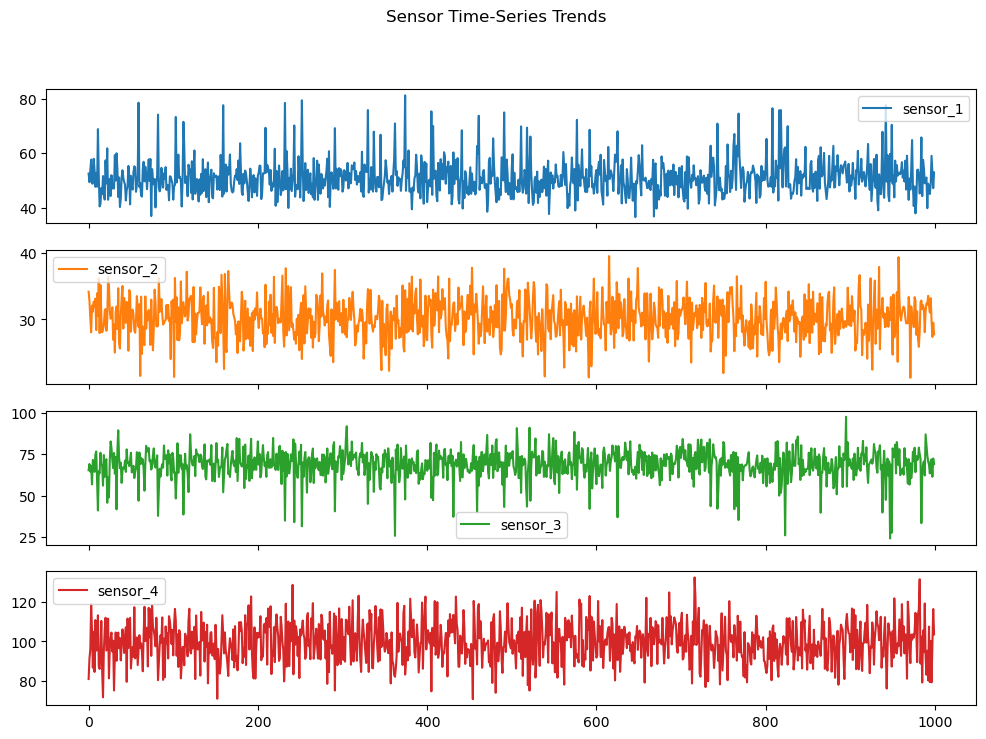

In [9]:
df[sensor_cols].plot(
    subplots=True,
    figsize=(12,8),
    title="Sensor Time-Series Trends"
)
plt.show()


### Sensor Trend Analysis

Time-series plots help visualize sensor behavior over time and reveal
spikes, drops, or gradual drifts that may indicate anomalies.


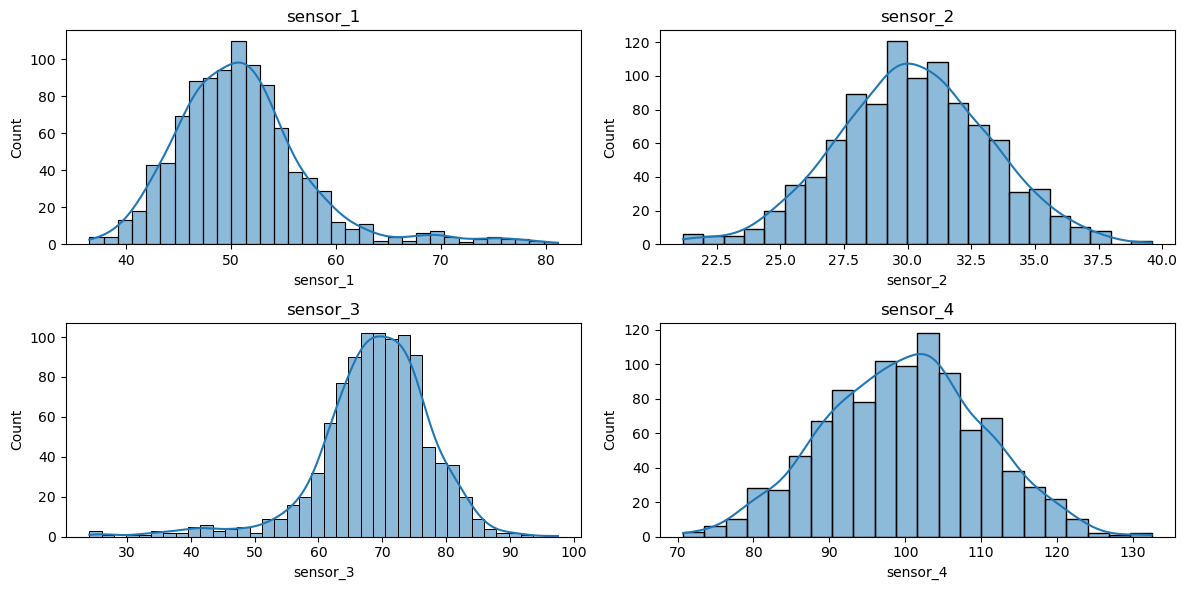

In [10]:
plt.figure(figsize=(12,6))
for i, col in enumerate(sensor_cols, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()


### Sensor Value Distributions

Distribution plots show the spread and skewness of sensor values.
Outliers in these distributions may correspond to anomalous observations.


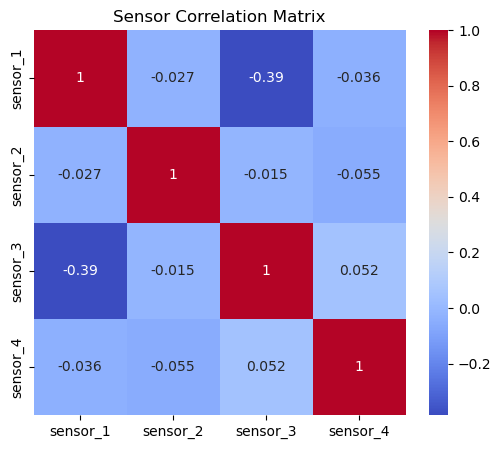

In [11]:
plt.figure(figsize=(6,5))
sns.heatmap(
    df[sensor_cols].corr(),
    annot=True,
    cmap="coolwarm"
)
plt.title("Sensor Correlation Matrix")
plt.show()


### Correlation Analysis

Correlation analysis highlights relationships between sensors.
Strong correlations may indicate interdependent sensor behavior,
which is important in multivariate anomaly detection.


## Data Preprocessing

Preprocessing is performed to prepare the data for anomaly detection
models by ensuring correct temporal order and consistent feature scaling.


In [12]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values("timestamp").reset_index(drop=True)

scaler = StandardScaler()
X = scaler.fit_transform(df[sensor_cols])

X[:5]


array([[ 0.21874395,  1.33257619, -0.38973733, -1.84010685],
       [-0.26889197,  0.85640475,  0.02644852, -0.81984254],
       [ 0.33468574, -0.01124009, -0.48168764, -0.38464745],
       [ 1.00690993, -0.71996493, -0.10173649,  1.85697634],
       [-0.34253062,  0.62930297, -1.34533293,  0.56035631]])

### Preprocessing Rationale

Sorting by timestamp preserves temporal order.
Standardization ensures that all sensor features contribute equally
to distance-based anomaly detection models.


## Isolation Forest Anomaly Detection

Isolation Forest is an unsupervised algorithm that isolates anomalies
by randomly partitioning the feature space. It is well-suited for
high-dimensional sensor data with rare anomalies.


In [13]:
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.05,
    random_state=42
)

df["anomaly_iforest"] = iso_forest.fit_predict(X)
df["anomaly_iforest"] = df["anomaly_iforest"].map({1: 0, -1: 1})

df[["timestamp", "anomaly_iforest"]].head()


,timestamp,anomaly_iforest
0,2024-01-01 00:00:00,0
1,2024-01-01 00:01:00,0
2,2024-01-01 00:02:00,0
3,2024-01-01 00:03:00,0
4,2024-01-01 00:04:00,0


In [14]:
df["anomaly_iforest"].mean()


0.05

### Anomaly Proportion Analysis

The proportion of detected anomalies helps validate whether the
contamination parameter is reasonable and not overly sensitive.


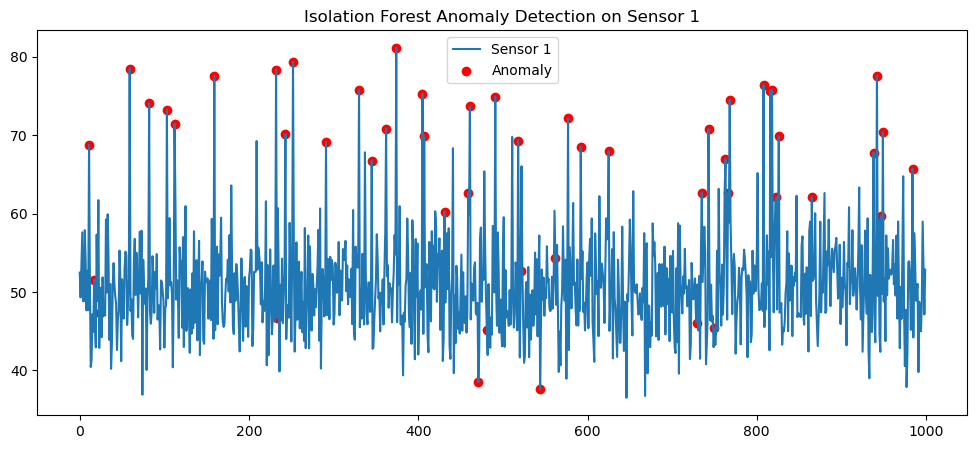

In [5]:
plt.figure(figsize=(12,5))
plt.plot(df["sensor_1"], label="Sensor 1")
plt.scatter(
    df[df["anomaly_iforest"] == 1].index,
    df[df["anomaly_iforest"] == 1]["sensor_1"],
    color="red",
    label="Anomaly"
)
plt.legend()
plt.title("Isolation Forest Anomaly Detection on Sensor 1")
plt.show()


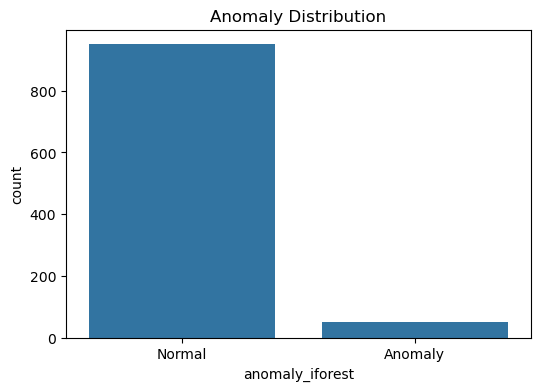

In [15]:
plt.figure(figsize=(6,4))
sns.countplot(x="anomaly_iforest", data=df)
plt.xticks([0,1], ["Normal", "Anomaly"])
plt.title("Anomaly Distribution")
plt.show()


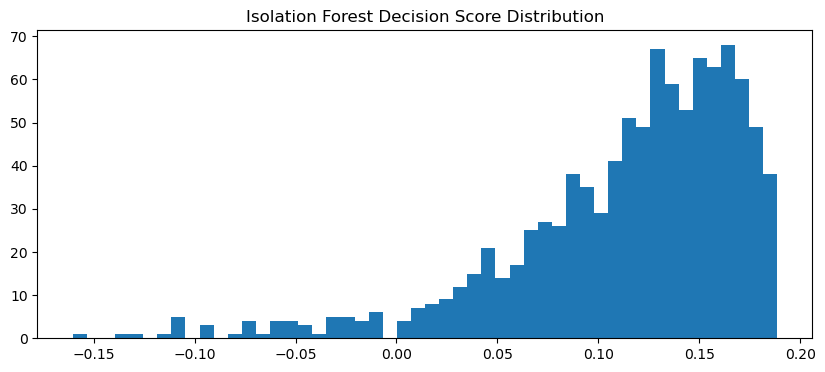

In [16]:
scores = iso_forest.decision_function(X)

plt.figure(figsize=(10,4))
plt.hist(scores, bins=50)
plt.title("Isolation Forest Decision Score Distribution")
plt.show()


## LSTM Autoencoder for Anomaly Detection

LSTM Autoencoders are designed to learn normal temporal patterns in
multivariate time-series data.

The model consists of:
- An encoder LSTM that compresses sequences
- A decoder LSTM that reconstructs the input

Anomalies are detected using reconstruction error, where higher
errors indicate abnormal sequences.


In [10]:
# Prepare data for LSTM Autoencoder
sensor_cols = ["sensor_1", "sensor_2", "sensor_3", "sensor_4"]

X_lstm = df[sensor_cols].values

scaler_lstm = StandardScaler()
X_lstm_scaled = scaler_lstm.fit_transform(X_lstm)

def create_sequences(data, seq_len=30):
    sequences = []
    for i in range(len(data) - seq_len):
        sequences.append(data[i:i+seq_len])
    return np.array(sequences)

X_seq = create_sequences(X_lstm_scaled, seq_len=30)
X_seq.shape


(970, 30, 4)

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam

timesteps = X_seq.shape[1]
features = X_seq.shape[2]

inputs = Input(shape=(timesteps, features))
encoded = LSTM(64, activation="relu")(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(), loss="mse")
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape          ┃      Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 30, 4)         │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm (LSTM)                   │ (None, 64)            │       17,664 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ repeat_vector (RepeatVector)  │ (None, 30, 64)        │            0 │
├───────────────────────────────┼───────────────────────┼──────────────┤
│ lstm_1 (LSTM)                 │ (None, 30, 4)         │        1,104 │
└───────────────────────────────┴───────────────────────┴──────────────┘

 Total params: 18,768 (73.31 KB)

 Trainable params: 18,768 (73.31 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = autoencoder.fit(
    X_seq,
    X_seq,
    epochs=20,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.9874 - val_loss: 1.1010
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.9816 - val_loss: 1.0995
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.9771 - val_loss: 1.0983
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9729 - val_loss: 1.0954
Epoch 5/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9709 - val_loss: 1.0916
Epoch 6/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.9714 - val_loss: 1.0897
Epoch 7/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.9679 - val_loss: 1.0894
Epoch 8/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9675 - val_loss: 1.0882
Epoch 9/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.9646 - val_loss: 1.0875
Epoch 10/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9625 - val_loss: 1.0869
Epoch 11/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.9612 - val_loss: 1.0935
Epoch 12/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.9

In [13]:
reconstructions = autoencoder.predict(X_seq)

reconstruction_error = np.mean(
    np.abs(reconstructions - X_seq),
    axis=(1, 2)
)

threshold = np.percentile(reconstruction_error, 95)
lstm_anomalies = reconstruction_error > threshold

threshold


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


np.float64(0.8782646567270244)

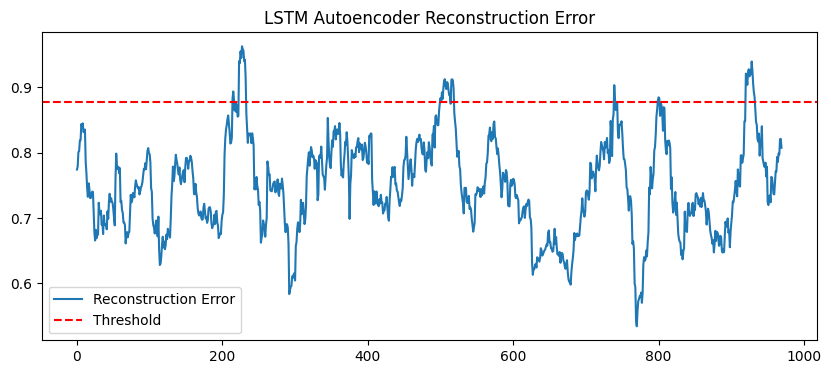

In [14]:
plt.figure(figsize=(10,4))
plt.plot(reconstruction_error, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("LSTM Autoencoder Reconstruction Error")
plt.show()


### LSTM Autoencoder – Pseudocode

Input: Multivariate time-series sequences  
Output: Reconstruction error per sequence  

1. Normalize sensor data
2. Create sliding window sequences
3. Train LSTM Autoencoder on normal data
4. Compute reconstruction error
5. Set anomaly threshold using percentile or validation data
6. Flag sequences above threshold as anomalies


## Conclusion

This project implements a complete and end-to-end multivariate time-series
anomaly detection pipeline for equipment sensor data.

Exploratory Data Analysis (EDA) and preprocessing were performed to understand
sensor behavior and ensure data quality. Time-based statistical features were
extracted using tsfresh and used with Isolation Forest for feature-based anomaly
detection.

Additionally, an LSTM Autoencoder was implemented to capture temporal
dependencies in multivariate sensor sequences. Anomalies were detected using
reconstruction error and percentile-based thresholding.

The combination of Isolation Forest and LSTM Autoencoder provides a robust
solution capable of detecting both point-wise and sequence-level anomalies,
making the approach suitable for real-world industrial monitoring and
predictive maintenance applications.
